In [1]:
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, zero_one_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, completeness_score, homogeneity_score, v_measure_score
import operator

import warnings
warnings.filterwarnings('ignore')

## Reading and processing dataset 

In [2]:
dataset_root = 'datasets/nsl-kdd'
train_file = os.path.join(dataset_root, 'KDDTrain+.txt')
test_file = os.path.join(dataset_root, 'KDDTest+.txt')

In [3]:
# Original KDD dataset feature names obtained from http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
header_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 
                'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 
                'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 
                'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 
                'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 
                'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 
                'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 
                'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type', 
                'success_pred']

In [4]:
# Differentiating between nominal, binary, and numeric features
# root_shell is marked as a continuous feature in the kddcup.names file, but it is supposed to be a binary feature 
# according to the dataset documentation
col_names = np.array(header_names)
nominal_idx = [1, 2, 3]
binary_idx = [6, 11, 13, 14, 20, 21]
numeric_idx = list(set(range(41)).difference(nominal_idx).difference(binary_idx))
nominal_cols = col_names[nominal_idx].tolist()
binary_cols = col_names[binary_idx].tolist()
numeric_cols = col_names[numeric_idx].tolist()

In [5]:
# training_attack_types.txt maps each of the 22 different attacks to 1 of 4 categories
# file obtained from http://kdd.ics.uci.edu/databases/kddcup99/training_attack_types
category = defaultdict(list)
category['benign'].append('normal')

with open('datasets/training_attack_types.txt', 'r') as f:
    for line in f.readlines():
        attack, cat = line.strip().split(' ')
        category[cat].append(attack)
        
# use the text file by converting it into a dictionary 
attack_mapping = dict((v,k) for k in category for v in category[k])

In [6]:
attack_mapping

{'normal': 'benign',
 'apache2': 'dos',
 'back': 'dos',
 'mailbomb': 'dos',
 'processtable': 'dos',
 'snmpgetattack': 'dos',
 'teardrop': 'dos',
 'smurf': 'dos',
 'land': 'dos',
 'neptune': 'dos',
 'pod': 'dos',
 'udpstorm': 'dos',
 'ps': 'u2r',
 'buffer_overflow': 'u2r',
 'perl': 'u2r',
 'rootkit': 'u2r',
 'loadmodule': 'u2r',
 'xterm': 'u2r',
 'sqlattack': 'u2r',
 'httptunnel': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'snmpguess': 'r2l',
 'imap': 'r2l',
 'spy': 'r2l',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'multihop': 'r2l',
 'phf': 'r2l',
 'named': 'r2l',
 'sendmail': 'r2l',
 'xlock': 'r2l',
 'xsnoop': 'r2l',
 'worm': 'probe',
 'nmap': 'probe',
 'ipsweep': 'probe',
 'portsweep': 'probe',
 'satan': 'probe',
 'mscan': 'probe',
 'saint': 'probe'}

## Generating and analyzing train and test sets

In [7]:
# read train file
train_df = pd.read_csv(train_file, names=header_names)
train_df['attack_category'] = train_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
train_df.drop(['success_pred'], axis=1, inplace=True)

# read test file
test_df = pd.read_csv(test_file, names=header_names)
test_df['attack_category'] = test_df['attack_type'] \
                                .map(lambda x: attack_mapping[x])
test_df.drop(['success_pred'], axis=1, inplace=True)

In [8]:
train_df
# there are 42 features originally

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type,attack_category
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,benign
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,benign
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,benign
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125968,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.06,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos
125969,8,udp,private,SF,105,145,0,0,0,0,...,0.96,0.01,0.01,0.00,0.00,0.00,0.00,0.00,normal,benign
125970,0,tcp,smtp,SF,2231,384,0,0,0,0,...,0.12,0.06,0.00,0.00,0.72,0.00,0.01,0.00,normal,benign
125971,0,tcp,klogin,S0,0,0,0,0,0,0,...,0.03,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,dos


In [9]:
print(len(train_df['attack_type'].unique()))
train_df['attack_category'].unique()
# the 23 attack types are transformed into five major attack category, which acts as the target 

23


array(['benign', 'dos', 'r2l', 'probe', 'u2r'], dtype=object)

In [12]:
# get the frequency count of attack type and attack category for visualizations
train_attack_types = train_df['attack_type'].value_counts()
train_attack_cats = train_df['attack_category'].value_counts()

In [13]:
train_attack_types

normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: attack_type, dtype: int64

In [20]:
test_attack_types = test_df['attack_type'].value_counts()
test_attack_cats = test_df['attack_category'].value_counts()

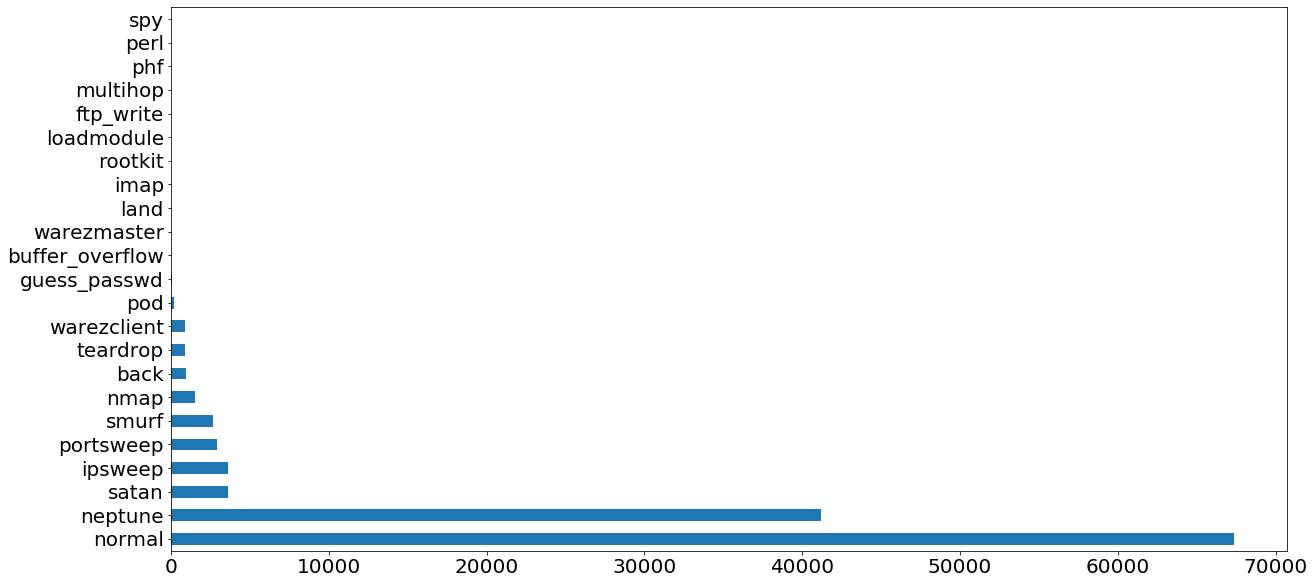

In [21]:
train_attack_types.plot(kind='barh', figsize=(20,10), fontsize=20)

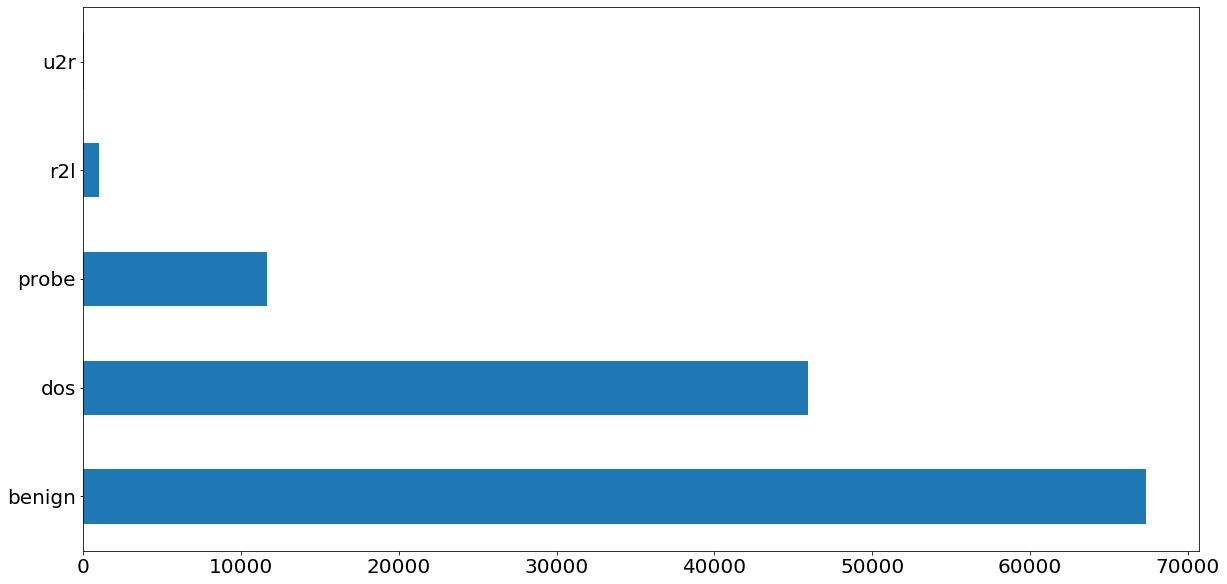

In [22]:
train_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=20)

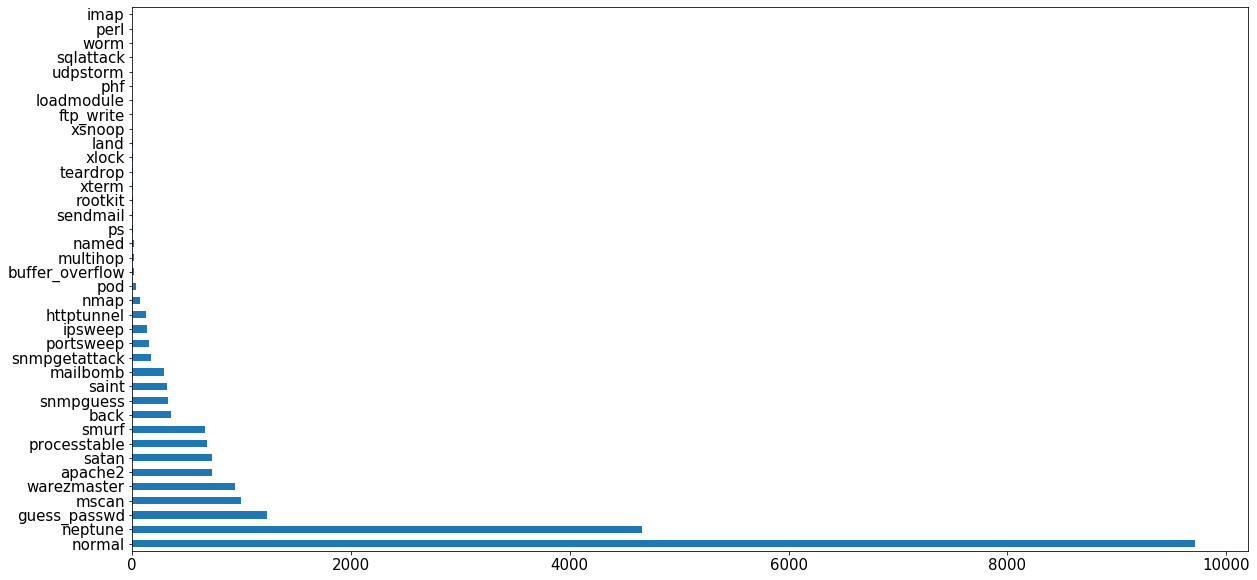

In [23]:
test_attack_types.plot(kind='barh', figsize=(20,10), fontsize=15)

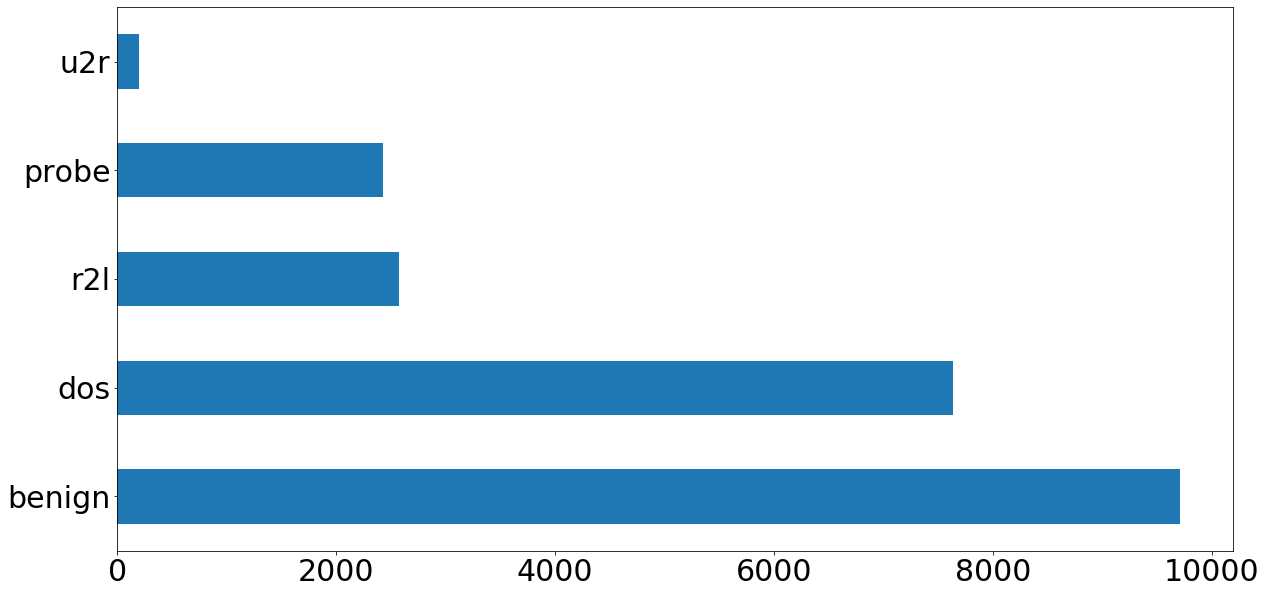

In [24]:
test_attack_cats.plot(kind='barh', figsize=(20,10), fontsize=30)

## Data preparation

In [19]:
# By definition, all of these features should have a min of 0.0 and a max of 1.0
train_df[binary_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
land,125973.0,0.000198,0.014086,0.0,0.0,0.0,0.0,1.0
logged_in,125973.0,0.395736,0.489010,0.0,0.0,0.0,1.0,1.0
root_shell,125973.0,0.001342,0.036603,0.0,0.0,0.0,0.0,1.0
su_attempted,125973.0,0.001103,0.045154,0.0,0.0,0.0,0.0,2.0
is_host_login,125973.0,0.000008,0.002817,0.0,0.0,0.0,0.0,1.0
is_guest_login,125973.0,0.009423,0.096612,0.0,0.0,0.0,0.0,1.0


In [20]:
# Wait a minute... the su_attempted column has a max value of 2.0?
train_df.groupby(['su_attempted']).size()

su_attempted
0    125893
1        21
2        59
dtype: int64

In [21]:
# by definition, su_attempted only has two values: 1 if ``su root'' command attempted; 0 otherwise 
# Let's fix this discrepancy and assume that su_attempted=2 -> su_attempted=0
train_df['su_attempted'].replace(2, 0, inplace=True)
test_df['su_attempted'].replace(2, 0, inplace=True)
train_df.groupby(['su_attempted']).size()

su_attempted
0    125952
1        21
dtype: int64

In [22]:
# Next, we notice that the num_outbound_cmds column only takes on one value!
train_df.groupby(['num_outbound_cmds']).size()

num_outbound_cmds
0    125973
dtype: int64

In [23]:
# Now, that's not a very useful feature - let's drop it from the dataset
train_df.drop('num_outbound_cmds', axis = 1, inplace=True)
test_df.drop('num_outbound_cmds', axis = 1, inplace=True)
numeric_cols.remove('num_outbound_cmds')

In [24]:
# separate dependent and independent variables 
train_Y = train_df['attack_category']
train_x_raw = train_df.drop(['attack_category','attack_type'], axis=1)
test_Y = test_df['attack_category']
test_x_raw = test_df.drop(['attack_category','attack_type'], axis=1)

In [25]:
test_df['attack_category']

0           dos
1           dos
2        benign
3         probe
4         probe
          ...  
22539    benign
22540    benign
22541       dos
22542    benign
22543     probe
Name: attack_category, Length: 22544, dtype: object

In [26]:
combined_df_raw = pd.concat([train_x_raw, test_x_raw])

# create dummy variables for categorical features
combined_df = pd.get_dummies(combined_df_raw, columns=nominal_cols, drop_first=True)

train_x = combined_df[:len(train_x_raw)]
test_x = combined_df[len(train_x_raw):]

# Store dummy variable feature names
dummy_variables = list(set(train_x)-set(combined_df_raw))

In [27]:
train_x.describe()
# there are now 118 variables after getting dummy

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,125973.00000,1.259730e+05,1.259730e+05,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,...,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,287.14465,4.556674e+04,1.977911e+04,0.000198,0.022687,0.000111,0.204409,0.001222,0.395736,0.279250,...,0.08917,0.012399,0.000818,0.019218,0.276655,0.002897,0.001008,0.000389,0.594929,0.002151
std,2604.51531,5.870331e+06,4.021269e+06,0.014086,0.253530,0.014366,2.149968,0.045239,0.489010,23.942042,...,0.28499,0.110661,0.028583,0.137292,0.447346,0.053750,0.031736,0.019719,0.490908,0.046332
min,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.00000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.00000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,0.00000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,42908.00000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
# Example statistics for the 'duration' feature before scaling
train_x['duration'].describe()

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
Name: duration, dtype: float64

In [29]:
# Experimenting with StandardScaler on the single 'duration' feature

durations = train_x['duration'].values.reshape(-1, 1)
standard_scaler = StandardScaler().fit(durations)
scaled_durations = standard_scaler.transform(durations)
pd.Series(scaled_durations.flatten()).describe()
# StandardScaler completely transformed the scale

count    1.259730e+05
mean     3.916911e-16
std      1.000004e+00
min     -1.102492e-01
25%     -1.102492e-01
50%     -1.102492e-01
75%     -1.102492e-01
max      1.636428e+01
dtype: float64

In [30]:
# Experimenting with MinMaxScaler on the single 'duration' feature
min_max_scaler = MinMaxScaler().fit(durations)
min_max_scaled_durations = min_max_scaler.transform(durations)
pd.Series(min_max_scaled_durations.flatten()).describe()
# MinMaxScaler does not work in this case because except for mean and max, all other scales remained the same

count    125973.000000
mean          0.006692
std           0.060700
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
dtype: float64

In [31]:
# Experimenting with RobustScaler on the single 'duration' feature
min_max_scaler = RobustScaler().fit(durations)
robust_scaled_durations = min_max_scaler.transform(durations)
pd.Series(robust_scaled_durations.flatten()).describe()
# all the numbers remained the same as original scaling so RobustScaler didnt work either

count    125973.00000
mean        287.14465
std        2604.51531
min           0.00000
25%           0.00000
50%           0.00000
75%           0.00000
max       42908.00000
dtype: float64

In [32]:
# Let's proceed with StandardScaler and apply to all the numeric columns
standard_scaler = StandardScaler().fit(train_x[numeric_cols])
train_x[numeric_cols] = \
    standard_scaler.transform(train_x[numeric_cols])
test_x[numeric_cols] = \
    standard_scaler.transform(test_x[numeric_cols])

In [33]:
train_x.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
count,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,1.259730e+05,1.259730e+05,1.259730e+05,125973.000000,1.259730e+05,...,125973.00000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000,125973.000000
mean,3.916911e-16,2.559517e-16,-3.472529e-16,0.000198,9.708754e-16,3.109539e-15,-7.629865e-15,8.220883e-16,0.395736,-2.468094e-15,...,0.08917,0.012399,0.000818,0.019218,0.276655,0.002897,0.001008,0.000389,0.594929,0.002151
std,1.000004e+00,1.000004e+00,1.000004e+00,0.014086,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,0.489010,1.000004e+00,...,0.28499,0.110661,0.028583,0.137292,0.447346,0.053750,0.031736,0.019719,0.490908,0.046332
min,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-1.102492e-01,-7.762241e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.102492e-01,-7.754745e-03,-4.918644e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,0.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,-1.102492e-01,-7.715224e-03,-4.790326e-03,0.000000,-8.948642e-02,-7.735985e-03,-9.507567e-02,-2.702282e-02,1.000000,-1.166364e-02,...,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.636428e+01,2.350675e+02,3.257486e+02,1.000000,1.174348e+01,2.088191e+02,3.571955e+01,1.104972e+02,1.000000,3.123689e+02,...,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# 5-class classification modeling

In [34]:
# Classifier 1: Decision Tree
classifier = DecisionTreeClassifier()
classifier.fit(train_x, train_Y)
pred_y = classifier.predict(test_x)
results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
print(results)
print(error)

[[9352   59  298    1    1]
 [1416 6125   95    0    0]
 [ 720  187 1516    0    0]
 [2337    0   14  217    6]
 [ 177    0    2    5   16]]
0.23589425124201557


In [35]:
# Classifier 2: KNN
classifier = KNeighborsClassifier(n_neighbors=1, n_jobs=-1)
classifier.fit(train_x, train_Y)
pred_y = classifier.predict(test_x)
results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
print(results)
print(error)

[[9457   57  193    2    2]
 [1675 5894   67    0    0]
 [ 670  156 1597    0    0]
 [2369    2   37  126   40]
 [ 176    0    4    7   13]]
0.24205997161107173


In [36]:
# Classifier 3: SVM with linear kernal
classifier = LinearSVC()
classifier.fit(train_x, train_Y)
pred_y = classifier.predict(test_x)
results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
print(results)
print(error)

[[9009  292  407    2    1]
 [1972 5654   10    0    0]
 [ 716  122 1498   87    0]
 [2471    1    1  101    0]
 [ 183    2    0    9    6]]
0.27838892831795603


Error: Decision Tree < KNN < SVM

Accuracy: Decision Tree > KNN > SVM

Therefore, Decision Tree outperformed the other two models with accuracy of about 76.3%.

## Dealing with class imbalance

In [37]:
test_Y.value_counts().apply(lambda x: x/float(len(test_Y)))

benign    0.430758
dos       0.338715
r2l       0.114177
probe     0.107479
u2r       0.008872
Name: attack_category, dtype: float64

In [38]:
train_Y.value_counts().apply(lambda x: x/float(len(train_Y)))
# more than half of the data belong to 'benign', while almost no data for 'u2r'
# imbalanced classes make the model hard to be trained for classes with very few data

benign    0.534583
dos       0.364578
probe     0.092528
r2l       0.007899
u2r       0.000413
Name: attack_category, dtype: float64

In [39]:
print(pd.Series(train_Y).value_counts())

benign    67343
dos       45927
probe     11656
r2l         995
u2r          52
Name: attack_category, dtype: int64


In [40]:
sm = SMOTE(sampling_strategy='auto', random_state=0)
train_x_sm, train_Y_sm = sm.fit_sample(train_x, train_Y)
print(pd.Series(train_Y_sm).value_counts())

r2l       67343
dos       67343
benign    67343
u2r       67343
probe     67343
Name: attack_category, dtype: int64


In [41]:
classifier = DecisionTreeClassifier()
classifier.fit(train_x_sm, train_Y_sm)
pred_y = classifier.predict(test_x)
results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
print(results)
print(error)

[[9403   71  215    6   16]
 [1416 5595  625    0    0]
 [ 438  161 1824    0    0]
 [2079    2  408   69   16]
 [  76    0   86   27   11]]
0.2502661462029808


First tried with upsampling, the number of probe records misclassified as the u2r class reduced but the overall error got worse. Generating about 67,000 'fake' records for the 'r2l' class seems unreasonable.

Next,try downsampling based on the upsampling results:

In [42]:
mean_class_size = int(pd.Series(train_Y).value_counts().sum()/5)
ratio = {'benign': mean_class_size,
         'dos': mean_class_size,
         'probe': mean_class_size,
         'r2l': mean_class_size,
         'u2r': mean_class_size}
rus = RandomUnderSampler(sampling_strategy=ratio, random_state=0, replacement=True)
train_x_rus, train_Y_rus = rus.fit_sample(train_x_sm, train_Y_sm)
print(pd.Series(train_Y_rus).value_counts())

benign    25194
r2l       25194
probe     25194
dos       25194
u2r       25194
Name: attack_category, dtype: int64


In [43]:
classifier = DecisionTreeClassifier()
classifier.fit(train_x_rus, train_Y_rus)
pred_y = classifier.predict(test_x)
results = confusion_matrix(test_Y, pred_y)
error = zero_one_loss(test_Y, pred_y)
print(results)
print(error)
# the performance improved slightly

[[8929   85  676   13    8]
 [1379 5414  843    0    0]
 [ 249  168 1937   67    2]
 [2137    0  106  318   13]
 [  93    0   73   16   18]]
0.2629524485450674


## Unsupervised learning

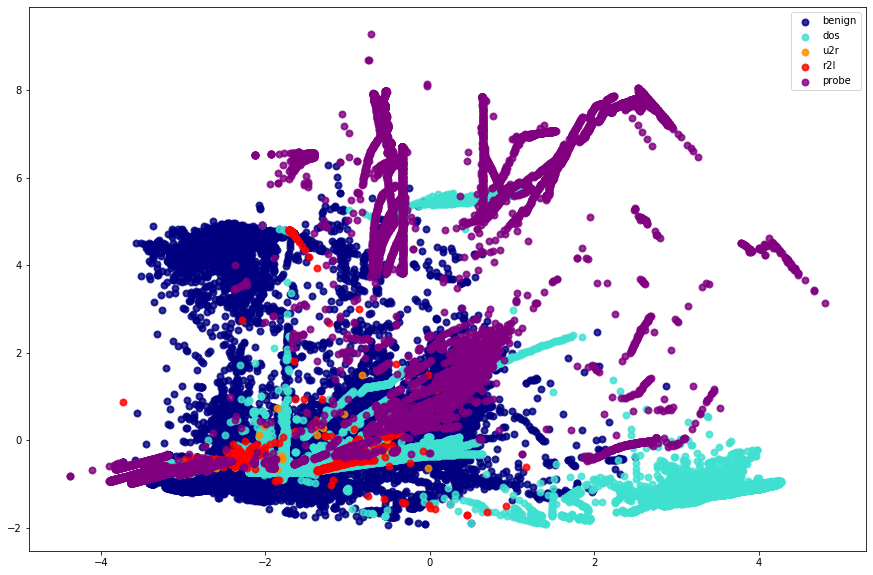

In [44]:
# Use PCA to reduce dimensionality so we can visualize the dataset on a 2d plot
pca = PCA(n_components=2)
train_x_pca_cont = pca.fit_transform(train_x[numeric_cols])

plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, category.keys()):
    plt.scatter(train_x_pca_cont[train_Y==cat, 0], train_x_pca_cont[train_Y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

The above graph visualizes the distribution of the five classes using two dimensions as performed by PCA (Principal Component Analysis). It can be observed that most records on the left of the graph are the benign class, which means the patterns for normal intrusions are relatively easy to be identified. However, detecting other types of attack such as probe and dos are challenging since they spread all over the graph and no clear patterns can be observed. This chart may look relatively messy, let's try clustering to group the observations and see the patterns. 


The most common unsupervised learning method is cluster analysis, which is used for exploratory data analysis to find hidden patterns or grouping in data. 

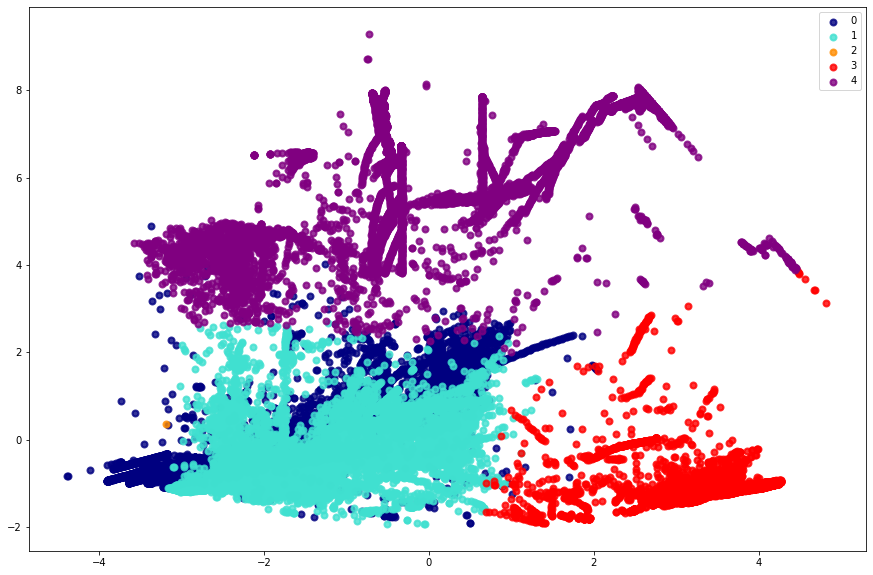

In [45]:
# Apply k-means (k=5, only using numeric cols) + PCA + plot

# Fit the training data to a k-means clustering estimator model
kmeans = KMeans(n_clusters=5, random_state=17).fit(train_x[numeric_cols])

# Retrieve the labels assigned to each training sample
kmeans_y = kmeans.labels_

# Plot in 2d with train_x_pca_cont
plt.figure(figsize=(15,10))
colors = ['navy', 'turquoise', 'darkorange', 'red', 'purple']

for color, cat in zip(colors, range(5)):
    plt.scatter(train_x_pca_cont[kmeans_y==cat, 0],
                train_x_pca_cont[kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

plt.show()

In [46]:
print('Total number of features: {}'.format(len(train_x.columns)))
print('Total number of continuous features: {}'.format(len(train_x[numeric_cols].columns)))

Total number of features: 118
Total number of continuous features: 31


In [47]:
print('Completeness: {}'.format(completeness_score(test_Y, pred_y)))
print('Homogeneity: {}'.format(homogeneity_score(test_Y, pred_y)))
print('V-measure: {}'.format(v_measure_score(test_Y, pred_y)))

Completeness: 0.46757102874467205
Homogeneity: 0.3891883075201559
V-measure: 0.42479415074934973


## Using Attribute Ratio (AR) for feature selection

Identifying important features in building intrusion detection system (IDS) makes the computation simple and reduces training time, therefore, is computationally efficient and effective

Attribute ratio (AR) is an effective method for feature selection and is calculated by average or frequency of features. To calculate AR, we have to calculate class ratio(CR).
Class Ratio (CR) is ratio of each class for Attribute i.

CR can be calculated as for numeric features: CR(j) = AVG(C(j)) / AVG(total) 

In [48]:
# calculating AVG(total) - mean for each feature
averages = train_df.loc[:, numeric_cols].mean()

In [49]:
# calculating AVG(C(j)) - mean for each class of a feature
averages_per_class = train_df[numeric_cols+['attack_category']].groupby('attack_category').mean()

In [50]:
averages_per_class
# the mean of duration for the benign class is 168.59, while for dos is only 0.01
# the mean of duration for the five classes are very different, so duration is likely to be a good feature to use 

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,num_root,num_file_creations,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
attack_category,,,,,,,,,,,,,,,,,,,,,
benign,168.587396,13133.279331,4329.685223,0.000000,0.000148,0.230655,0.001381,0.507076,0.562924,0.022274,...,147.431923,190.285761,0.811875,0.040134,0.121726,0.025996,0.013930,0.006116,0.046589,0.044698
dos,0.006227,1176.321162,169.201537,0.062229,0.000000,0.039889,0.000000,0.019226,0.000000,0.000000,...,244.600475,26.524005,0.123423,0.066333,0.049492,0.001647,0.747922,0.744434,0.157569,0.151286
probe,2074.858185,385679.838367,181074.911805,0.000000,0.000000,0.001630,0.000343,0.000601,0.000601,0.001716,...,145.204101,42.367193,0.390825,0.401263,0.651840,0.187343,0.044757,0.039799,0.389717,0.441030
r2l,633.417085,307727.300503,81822.026131,0.000000,0.003015,8.334673,0.056281,0.077387,0.111558,0.035176,...,89.037186,42.440201,0.727377,0.021307,0.596915,0.085739,0.023849,0.015960,0.051116,0.047367
u2r,80.942308,906.230769,5141.961538,0.000000,0.019231,1.403846,0.019231,1.211538,0.788462,0.788462,...,47.769231,9.884615,0.781154,0.040000,0.568269,0.081154,0.000000,0.004808,0.039615,0.019038


𝐀𝐑(𝐢) = 𝐌𝐀𝐗(𝐂𝐑(𝐣))

In [51]:
AR = {}
for col in numeric_cols:
    AR[col] = max(averages_per_class[col]/averages[col]) # 𝐂𝐑(𝐣) = averages_per_class[col]/averages[col]
AR #AR for numerical features

{'duration': 7.225829157212557,
 'src_bytes': 8.464064204948945,
 'dst_bytes': 9.154854355343401,
 'wrong_fragment': 2.742896335488928,
 'urgent': 173.03983516483518,
 'hot': 40.77451681709518,
 'num_failed_logins': 46.03855641845592,
 'num_compromised': 4.338539274983927,
 'num_root': 2.6091432537726016,
 'num_file_creations': 62.23362492770388,
 'num_shells': 326.11353550295854,
 'num_access_files': 4.694879248658319,
 'count': 2.1174082949142403,
 'srv_count': 1.1773191099992069,
 'serror_rate': 2.6310546426370025,
 'srv_serror_rate': 2.6432463184901405,
 'rerror_rate': 3.645586087828437,
 'srv_rerror_rate': 3.6677418023254122,
 'same_srv_rate': 1.507961200604778,
 'diff_srv_rate': 4.069085485068517,
 'srv_diff_host_rate': 3.0815657101101674,
 'dst_host_count': 1.3428596865228266,
 'dst_host_srv_count': 1.6453161847397422,
 'dst_host_same_srv_rate': 1.5575788279744123,
 'dst_host_diff_srv_rate': 4.837341848973267,
 'dst_host_same_src_port_rate': 4.3930803788834885,
 'dst_host_srv_di

CR for binary features: CR(j) = Frequency(1) / Frequency(0)

In [52]:
# calculating AR for binary features
def binary_AR(df, col):
    series_zero = train_df[train_df[col] == 0].groupby('attack_category').size()
    series_one = train_df[train_df[col] == 1].groupby('attack_category').size()
    return max(series_one/series_zero)

In [53]:
# relabeling the df with a 2-class target for binary classification
labels2 = ['normal', 'attack']
train_df['labels2'] = train_df.apply(lambda x: 'normal' if 'normal' in x['attack_type'] else 'attack', axis=1)
test_df['labels2'] = test_df.apply(lambda x: 'normal' if 'normal' in x['attack_type'] else 'attack', axis=1)

In [54]:
# repeat the step of getting dummies to regenerate dummies for dfs with new labels
combined_df = pd.concat([train_df, test_df])
original_cols = combined_df.columns
combined_df = pd.get_dummies(combined_df, columns=nominal_cols, drop_first=True)
added_cols = list(set(combined_df.columns)-set(original_cols))

In [55]:
# split train and test
train_df = combined_df[:len(train_df)]
test_df = combined_df[len(train_df):]

In [56]:
for col in binary_cols+dummy_variables:
    cur_AR = binary_AR(train_df, col)
    if cur_AR:
        AR[col] = cur_AR

In [57]:
len(binary_cols+added_cols)

87

The AR for each feature indicates how the values for each class of the feature differs. The larger the AR of a given feature, the greater the difference between any of the two classes for the specfic feature, and the more important the feature for classification. 

In [58]:
# sorted AR values in descending order
AR = dict((k, v) for k,v in AR.items() if not np.isnan(v))
sorted_AR = sorted(AR.items(), key=lambda x:x[1], reverse=True)
sorted_AR
# features with top AR values are useful features 

[('num_shells', 326.11353550295854),
 ('urgent', 173.03983516483518),
 ('num_file_creations', 62.23362492770388),
 ('flag_SF', 51.0),
 ('num_failed_logins', 46.03855641845592),
 ('hot', 40.77451681709518),
 ('protocol_type_tcp', 16.333333333333332),
 ('logged_in', 10.569767441860465),
 ('dst_bytes', 9.154854355343401),
 ('src_bytes', 8.464064204948945),
 ('duration', 7.225829157212557),
 ('dst_host_srv_diff_host_rate', 5.7568806827547),
 ('dst_host_diff_srv_rate', 4.837341848973267),
 ('num_access_files', 4.694879248658319),
 ('dst_host_same_src_port_rate', 4.3930803788834885),
 ('num_compromised', 4.338539274983927),
 ('diff_srv_rate', 4.069085485068517),
 ('dst_host_srv_rerror_rate', 3.667920527965804),
 ('srv_rerror_rate', 3.6677418023254122),
 ('rerror_rate', 3.645586087828437),
 ('dst_host_rerror_rate', 3.2795669242442695),
 ('srv_diff_host_rate', 3.0815657101101674),
 ('flag_S0', 2.965034965034965),
 ('wrong_fragment', 2.742896335488928),
 ('dst_host_srv_serror_rate', 2.673159595

In [59]:
# keep features with AR value >= 1 (this benchmark could be set differently)
features_to_use = []
for x,y in sorted_AR:
    if y >= 1:
        features_to_use.append(x)
features_to_use

['num_shells',
 'urgent',
 'num_file_creations',
 'flag_SF',
 'num_failed_logins',
 'hot',
 'protocol_type_tcp',
 'logged_in',
 'dst_bytes',
 'src_bytes',
 'duration',
 'dst_host_srv_diff_host_rate',
 'dst_host_diff_srv_rate',
 'num_access_files',
 'dst_host_same_src_port_rate',
 'num_compromised',
 'diff_srv_rate',
 'dst_host_srv_rerror_rate',
 'srv_rerror_rate',
 'rerror_rate',
 'dst_host_rerror_rate',
 'srv_diff_host_rate',
 'flag_S0',
 'wrong_fragment',
 'dst_host_srv_serror_rate',
 'srv_serror_rate',
 'serror_rate',
 'dst_host_serror_rate',
 'num_root',
 'count',
 'service_telnet',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'service_ftp_data',
 'same_srv_rate',
 'dst_host_count',
 'service_http',
 'srv_count',
 'root_shell']

In [60]:
len(features_to_use)
# after feature selection, there are only 39 features

39

## Applying advanced ensembling to build a network intrusion detector

Now, we will build a predictive model capable of distinguishing between bad'' connections, called intrusions or attacks, and good'' normal connections. Therefore, we can simplify the problem to a binary classification problem, which is likely to produce a more accurate results than five-class.

In [61]:
# keep only 39 features selected by AR
train_df_trimmed = train_df[features_to_use]
test_df_trimmed = test_df[features_to_use]

In [62]:
# Rescaling is necessary after reducing dimensions
standard_scaler = StandardScaler()
numeric_cols_to_use = list(set(numeric_cols).intersection(features_to_use))
train_df_trimmed[numeric_cols_to_use] = standard_scaler.fit_transform(train_df_trimmed[numeric_cols_to_use])
test_df_trimmed[numeric_cols_to_use] = standard_scaler.transform(test_df_trimmed[numeric_cols_to_use])

In [63]:
# first try to create eight clusters using K-means
kmeans = KMeans(n_clusters=8, random_state=17) 
kmeans.fit(train_df_trimmed[numeric_cols_to_use])
kmeans_train_y = kmeans.labels_

In [64]:
# transfer dependent variables from five classes to dummy variable
train_Y_bin = train_Y.apply(lambda x: 0 if x is 'benign' else 1)
test_Y_bin = test_Y.apply(lambda x: 0 if x is 'benign' else 1)
train_Y_bin

0         0
1         0
2         1
3         0
4         0
         ..
125968    1
125969    0
125970    0
125971    1
125972    0
Name: attack_category, Length: 125973, dtype: int64

In [65]:
# for training set: frequency count of normal (0) and attack (1) for the eight clusters
pd.crosstab(kmeans_train_y, train_Y_bin)

attack_category,0,1
row_0,,
0,59596,3883
1,2803,12243
2,123,34707
3,604,4324
4,0,884
5,3697,2300
6,1,0
7,519,289


In [66]:
# add the clustering results training sets
train_df['kmeans_y'] = kmeans_train_y
train_df_trimmed['kmeans_y'] = kmeans_train_y
train_df.labels2=train_Y_bin

# predict clusters for testing set
kmeans_test_y = kmeans.predict(test_df_trimmed[numeric_cols_to_use])
test_df['kmeans_y'] = kmeans_test_y
test_df.labels2=test_Y_bin
test_df.labels2

0        1
1        1
2        0
3        1
4        1
        ..
22539    0
22540    0
22541    1
22542    0
22543    1
Name: labels2, Length: 22544, dtype: int64

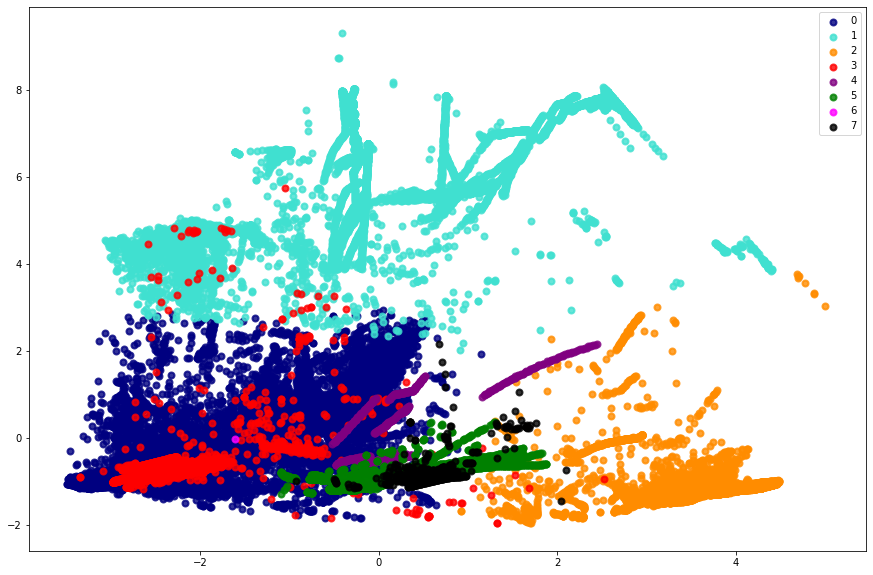

In [67]:
# use pca to plot the clustering results
pca8 = PCA(n_components=2)
train_df_trimmed_pca8 = pca8.fit_transform(train_df_trimmed)
plt.figure(figsize=(15,10))
colors8 = ['navy', 'turquoise', 'darkorange', 'red', 'purple', 'green', 'magenta', 'black']
labels8 = [0,1,2,3,4,5,6,7]
for color, cat in zip(colors8, labels8):
    plt.scatter(train_df_trimmed_pca8[train_df.kmeans_y==cat, 0], train_df_trimmed_pca8[train_df.kmeans_y==cat, 1],
                color=color, alpha=.8, lw=2, label=cat)
plt.legend(loc='best', shadow=False, scatterpoints=1)

Ensembling strategy

1.	For clusters with an aggregate size of fewer than 200 samples, we consider them outliers and assign them the normal label.

2.	For clusters with more than 95% of samples belonging to a single class, (either attack or benign) we assign the dominant label to the entire cluster.

3.	For each of the remaining clusters, we train a separate random forest classifier

In [68]:
# for testing set: frequency count of normal (0) and attack (1) for the eight clusters
pd.crosstab(test_df.kmeans_y, test_df.labels2)

labels2,0,1
kmeans_y,,
0,8764,4758
1,85,5160
2,8,1997
3,49,412
4,37,8
5,759,498
7,9,0


### Cluster 0 - Random Forest Classifier (Strategy Option 3)

In [69]:
train_y0 = train_df[train_df.kmeans_y==0]
test_y0 = test_df[test_df.kmeans_y==0]
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['labels2', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['labels2'])
pred_y0 = rfc.predict(test_y0.drop(['labels2', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print(confusion_matrix(test_y0['labels2'], pred_y0))
print("The accuracy for cluster {} is {}, with {} records".format(0, accuracy_score(pred_y0, test_y0['labels2']), 
                                                                  accuracy_score(pred_y0, test_y0['labels2'], 
                                                                                 normalize=False)))

[[8612  152]
 [3751 1007]]
The accuracy for cluster 0 is 0.7113592663807129, with 9619 records


### Cluster 1 - Dominant Label Zero (Strategy Option 2)

In [70]:
print(confusion_matrix(test_df[test_df.kmeans_y==1]['labels2'], np.ones(len(test_df[test_df.kmeans_y==1]))))
print("The accuracy for cluster 1 is", accuracy_score(np.ones(len(test_df[test_df.kmeans_y==1])), 
                                                      test_df[test_df.kmeans_y==1]['labels2']))

[[   0   85]
 [   0 5160]]
The accuracy for cluster 1 is 0.9837940896091516


### Cluster 2 - Dominant Label Zero (Strategy Option 2)

In [71]:
print(confusion_matrix(test_df[test_df.kmeans_y==2]['labels2'], np.ones(len(test_df[test_df.kmeans_y==2]))))
print("The accuracy for cluster 2 is", accuracy_score(np.ones(len(test_df[test_df.kmeans_y==2])), 
                                                      test_df[test_df.kmeans_y==2]['labels2']))

[[   0    8]
 [   0 1997]]
The accuracy for cluster 2 is 0.9960099750623441


### Cluster 3 - Random Forest Classifier (Strategy Option 3)

In [72]:
train_y0 = train_df[train_df.kmeans_y==3]
test_y0 = test_df[test_df.kmeans_y==3]
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['labels2', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['labels2'])
pred_y0 = rfc.predict(test_y0.drop(['labels2', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print(confusion_matrix(test_y0['labels2'], pred_y0))
print("The accuracy for cluster {} is {}, with {} records".format(3, accuracy_score(pred_y0, test_y0['labels2']), 
                                                                  accuracy_score(pred_y0, test_y0['labels2'], 
                                                                                 normalize=False)))

[[ 38  11]
 [ 21 391]]
The accuracy for cluster 3 is 0.93058568329718, with 429 records


### Cluster 4 - Outlier/Attack (Strategy Option 1)

In [73]:
print(confusion_matrix(test_df[test_df.kmeans_y==4]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==4]))))
print("The accuracy for cluster 4 is", accuracy_score(np.zeros(len(test_df[test_df.kmeans_y==4])), 
                                                      test_df[test_df.kmeans_y==4]['labels2']))

[[37  0]
 [ 8  0]]
The accuracy for cluster 4 is 0.8222222222222222


### Cluster 5 - Random Forest Classifier (Strategy Option 3)

In [74]:
train_y0 = train_df[train_df.kmeans_y==5]
test_y0 = test_df[test_df.kmeans_y==5]
rfc = RandomForestClassifier(n_estimators=500, max_depth=20, random_state=17).fit(train_y0.drop(['labels2', 'kmeans_y', 'attack_category', 'attack_type'], axis=1), train_y0['labels2'])
pred_y0 = rfc.predict(test_y0.drop(['labels2', 'kmeans_y', 'attack_category', 'attack_type'], axis=1))
print(confusion_matrix(test_y0['labels2'], pred_y0))
print("The accuracy for cluster {} is {}, with {} records".format(5, accuracy_score(pred_y0, test_y0['labels2']), 
                                                                  accuracy_score(pred_y0, test_y0['labels2'], 
                                                                                 normalize=False)))

[[759   0]
 [  1 497]]
The accuracy for cluster 5 is 0.9992044550517104, with 1256 records


### Cluster 6 - Empty Cluster

### Cluster 7 - Outlier/Attack (Strategy Option 1)

In [75]:
print(confusion_matrix(test_df[test_df.kmeans_y==7]['labels2'], np.zeros(len(test_df[test_df.kmeans_y==7]))))
print("The accuracy for cluster 7 is", accuracy_score(np.zeros(len(test_df[test_df.kmeans_y==7])), 
                                                      test_df[test_df.kmeans_y==7]['labels2']))

[[9]]
The accuracy for cluster 7 is 1.0


### Combined Results: k-means + Random Forest Classifier ensembling with AR feature selection

Accuracy = (TP+TN) / (TP+FN+FP+TN)

In [76]:
# combined results:
num_samples = 22544
true_neg = 1015 + 5160 + 1997 + 391 + 497 + 9
true_pos = 8612 + 37 + 38 + 759
print('Overall Accuracy %: {}'.format((true_pos+true_neg)/num_samples*100))

Overall Accuracy %: 82.12828246983676


The final model performed better than the models used for 5-class classification.